# Voice Activity Detection (VAD) using WebRTC VAD

This notebook demonstrates how to perform Voice Activity Detection (VAD) using the `webrtcvad` library. We will:
1. Load and preprocess an audio file.
2. Apply the VAD algorithm to detect speech segments.
3. Visualize and output the detected speech segments.


## Step 1: Install Requirements

In [1]:
# Install required packages
!pip install webrtcvad numpy soundfile matplotlib scipy

## Step 2: Load Libraries

In [2]:
# Import necessary libraries
import webrtcvad
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.io.wavfile import write

## Step 3: Load and Preprocess the Audio File

We start by loading an audio file and converting it to a format suitable for processing by WebRTC VAD. The audio needs to be in 16-bit PCM format and have a valid sample rate (8000, 16000, 32000, or 48000 Hz).

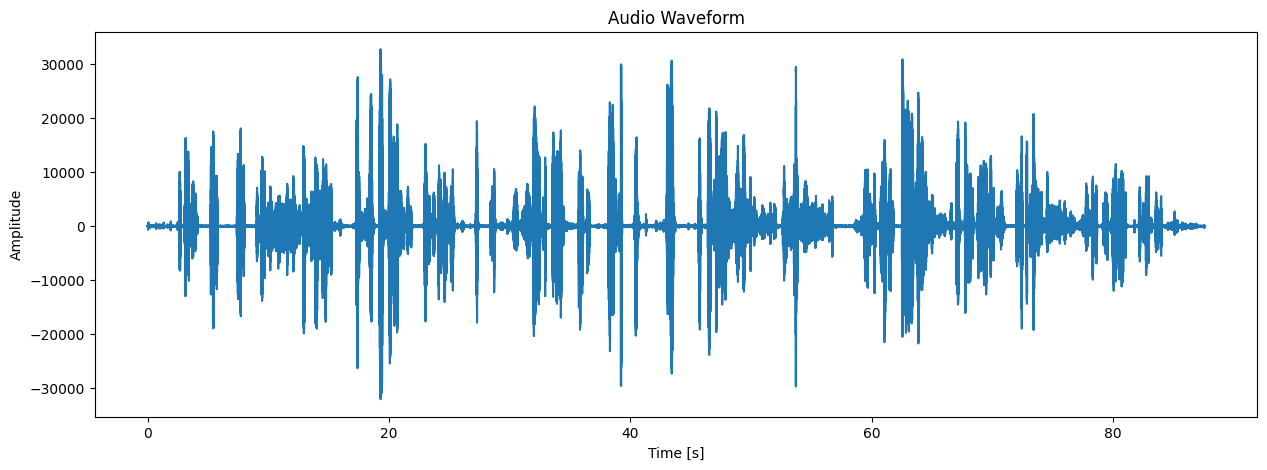

In [4]:
# Function to convert audio to PCM format
def convert_audio_to_pcm(audio, sample_rate):
    # Ensure audio is mono
    if audio.ndim > 1:
        audio = np.mean(audio, axis=1)
    
    # Convert to 16-bit PCM
    audio = (audio * 32767).astype(np.int16)
    return audio

# Load the audio file
audio_filepath = "../../test_pcm.wav"
audio, sample_rate = sf.read(audio_filepath)
audio = convert_audio_to_pcm(audio, sample_rate)

# Ensure sample rate is valid (must be 8000, 16000, 32000, or 48000 Hz)
assert sample_rate in [8000, 16000, 32000, 48000], "Invalid sample rate"

# Plot the audio waveform
plt.figure(figsize=(15, 5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.title('Audio Waveform')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()


## Step 4: Apply WebRTC VAD

Next, we apply the WebRTC VAD algorithm to detect speech segments in the audio.
We split the audio into frames of 30 ms duration and check each frame for
speech.

Finally we print out the segments and audio file statistics.

In [5]:
# Initialize WebRTC VAD
vad = webrtcvad.Vad()
vad.set_mode(3)  # 0: Normal, 3: Aggressive

# Define the frame duration (must be 10, 20, or 30 ms)
frame_duration = 30
frame_length = int(sample_rate * frame_duration / 1000)
assert len(audio) >= frame_length, "Audio length is shorter than frame length"

# Split audio into frames
frames = [audio[i:i + frame_length] for i in range(0, len(audio), frame_length) if len(audio[i:i + frame_length]) == frame_length]

# Perform VAD
speech_segments = []
current_segment = None

for i, frame in enumerate(frames):
    is_speech = vad.is_speech(frame.tobytes(), sample_rate)
    if is_speech:
        if current_segment is None:
            current_segment = [i * frame_duration / 1000, (i + 1) * frame_duration / 1000]
        else:
            current_segment[1] = (i + 1) * frame_duration / 1000
    else:
        if current_segment is not None:
            speech_segments.append(current_segment)
            current_segment = None

if current_segment is not None:
    speech_segments.append(current_segment)

# Print the VAD segments
print("Detected speech segments (in seconds):")
for start, end in speech_segments:
    print(f"Start: {start:.2f}, End: {end:.2f}")

# Print VAD statistics: Number of speech segments, total duration of speech
# segments, and speech ratio
num_segments = len(speech_segments)
total_duration = sum(end - start for start, end in speech_segments)
speech_ratio = total_duration / (len(audio) / sample_rate)
total_audio_length = len(audio) / sample_rate
print(f"\nNumber of speech segments: {num_segments}")
print(f"Total length of audio: {total_audio_length:.2f} seconds")
print(f"Total duration of speech segments: {total_duration:.2f} seconds")
print(f"Speech ratio: {speech_ratio:.2f}")


Detected speech segments (in seconds):
Start: 1.92, End: 2.01
Start: 2.49, End: 2.58
Start: 2.61, End: 2.85
Start: 3.03, End: 4.23
Start: 5.19, End: 5.91
Start: 7.38, End: 8.16
Start: 9.03, End: 12.00
Start: 12.06, End: 13.32
Start: 13.38, End: 15.39
Start: 15.51, End: 15.60
Start: 15.75, End: 15.84
Start: 15.90, End: 16.11
Start: 17.01, End: 17.13
Start: 17.25, End: 18.15
Start: 18.18, End: 18.87
Start: 19.17, End: 19.89
Start: 19.92, End: 21.51
Start: 21.54, End: 21.96
Start: 22.89, End: 23.97
Start: 24.03, End: 24.93
Start: 24.99, End: 25.50
Start: 25.65, End: 25.77
Start: 25.98, End: 26.19
Start: 27.18, End: 27.54
Start: 28.41, End: 28.92
Start: 29.22, End: 29.55
Start: 29.79, End: 29.88
Start: 30.30, End: 32.64
Start: 32.73, End: 33.18
Start: 33.51, End: 34.98
Start: 35.70, End: 36.21
Start: 36.24, End: 36.69
Start: 38.10, End: 39.39
Start: 40.29, End: 40.83
Start: 41.28, End: 41.40
Start: 42.09, End: 42.24
Start: 42.75, End: 42.90
Start: 42.96, End: 43.80
Start: 45.54, End: 45.99

## Step 5: Visualize the Detected Speech Segments

We visualize the detected speech segments on the audio waveform to better understand where speech occurs.

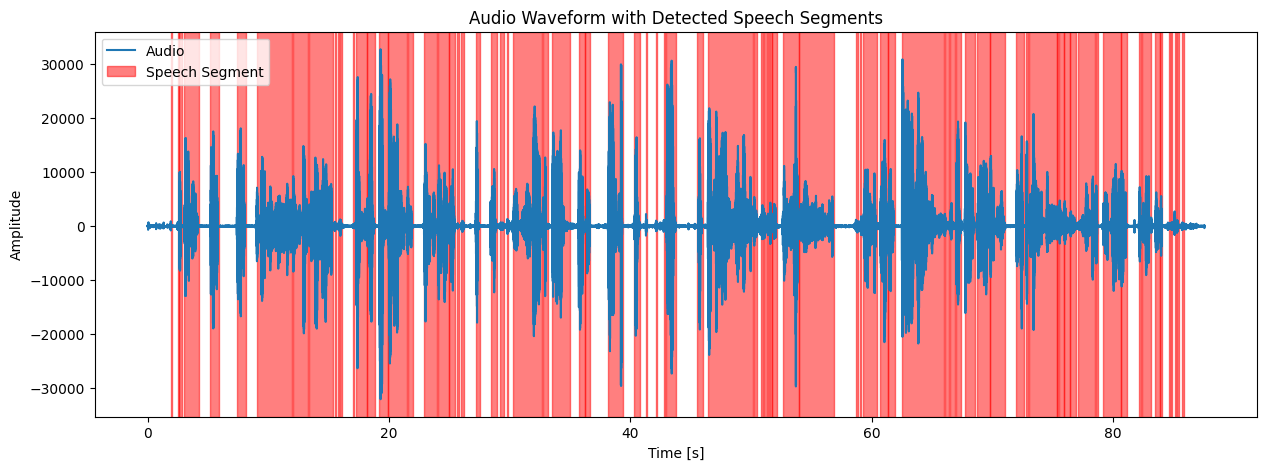

In [6]:
# Plot the audio waveform with detected speech segments
plt.figure(figsize=(15, 5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio, label='Audio')
for start, end in speech_segments:
    plt.axvspan(start, end, color='red', alpha=0.5, label='Speech Segment' if start == speech_segments[0][0] else "")
plt.title('Audio Waveform with Detected Speech Segments')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


## Conclusion

In this notebook, we demonstrated how to use the `webrtcvad` library to detect speech segments in an audio file. We loaded and preprocessed the audio, applied the VAD algorithm, and visualized the detected speech segments. Optionally, we saved the detected speech segments as separate audio files for further analysis.